# AG News - Data Preparation Pipeline

**Task**: Single-label News Topic Classification  
**Dataset**: [AG News](https://huggingface.co/datasets/sh0416/ag_news)  
**Classes**: World, Sports, Business, Sci/Tech  

---

## Pipeline Overview

1. Environment Setup & Dependencies
2. Dataset Loading & Exploration
3. Data Quality Analysis
4. Text Preprocessing
5. Tokenization Strategy
6. Dataset Preparation for Training
7. Save Processed Data

## 1. Environment Setup

In [1]:
!pip install -q transformers datasets accelerate evaluate scikit-learn
!pip install -q matplotlib seaborn pandas numpy

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 84.1/84.1 kB 5.0 MB/s eta 0:00:00


In [2]:
import os
import json
import warnings
warnings.filterwarnings('ignore')

import numpy as np
import pandas as pd
from collections import Counter

from datasets import load_dataset, DatasetDict, Dataset
from transformers import AutoTokenizer

import matplotlib.pyplot as plt
import seaborn as sns

plt.style.use('seaborn-v0_8-whitegrid')
sns.set_palette('husl')

print("✅ All imports successful!")

✅ All imports successful!


In [3]:
class Config:
    DATASET_NAME = "sh0416/ag_news"
    
    MODEL_CHECKPOINTS = {
        'bert-base': 'bert-base-uncased',
        'distilbert': 'distilbert-base-uncased',
        'tinybert': 'huawei-noah/TinyBERT_General_4L_312D'
    }
    
    DEFAULT_TOKENIZER = 'bert-base-uncased'
    
    MAX_LENGTH = 128
    PADDING = 'max_length'
    TRUNCATION = True
    
    LABEL_NAMES = ['World', 'Sports', 'Business', 'Sci/Tech']
    NUM_LABELS = 4
    
    DATA_DIR = './processed_data'
    
    SEED = 42

config = Config()

os.makedirs(config.DATA_DIR, exist_ok=True)

print("📋 Configuration loaded!")
print(f"   Dataset: {config.DATASET_NAME}")
print(f"   Max Length: {config.MAX_LENGTH}")
print(f"   Labels: {config.LABEL_NAMES}")

📋 Configuration loaded!
   Dataset: sh0416/ag_news
   Max Length: 128
   Labels: ['World', 'Sports', 'Business', 'Sci/Tech']


## 2. Dataset Loading & Exploration

In [4]:
print("📥 Loading AG News dataset...")
raw_dataset = load_dataset(config.DATASET_NAME)

print("\n✅ Dataset loaded successfully!")
print(raw_dataset)

📥 Loading AG News dataset...


README.md: 0.00B [00:00, ?B/s]

train.jsonl:   0%|          | 0.00/33.7M [00:00<?, ?B/s]

test.jsonl: 0.00B [00:00, ?B/s]

Generating train split:   0%|          | 0/120000 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/7600 [00:00<?, ? examples/s]


✅ Dataset loaded successfully!
DatasetDict({
    train: Dataset({
        features: ['label', 'title', 'description'],
        num_rows: 120000
    })
    test: Dataset({
        features: ['label', 'title', 'description'],
        num_rows: 7600
    })
})


In [ ]:
print("📊 Dataset Structure:")
print("="*50)

for split_name, split_data in raw_dataset.items():
    print(f"\n{split_name.upper()}:")
    print(f"  Samples: {len(split_data):,}")
    print(f"  Features: {split_data.features}")

📊 Dataset Structure:

TRAIN:
  Samples: 120,000
  Features: {'label': Value('int64'), 'title': Value('string'), 'description': Value('string')}

TEST:
  Samples: 7,600
  Features: {'label': Value('int64'), 'title': Value('string'), 'description': Value('string')}


In [6]:
print("📝 Sample Data Points:")
print("="*80)

for i in range(3):
    sample = raw_dataset['train'][i]
    print(f"\n--- Sample {i+1} ---")
    print(f"Label: {sample['label']} ({config.LABEL_NAMES[sample['label']]})")
    print(f"Text: {sample['description'][:200]}...")

📝 Sample Data Points:

--- Sample 1 ---
Label: 3 (Sci/Tech)
Text: Reuters - Short-sellers, Wall Street's dwindling\band of ultra-cynics, are seeing green again....

--- Sample 2 ---
Label: 3 (Sci/Tech)
Text: Reuters - Private investment firm Carlyle Group,\which has a reputation for making well-timed and occasionally\controversial plays in the defense industry, has quietly placed\its bets on another part ...

--- Sample 3 ---
Label: 3 (Sci/Tech)
Text: Reuters - Soaring crude prices plus worries\about the economy and the outlook for earnings are expected to\hang over the stock market next week during the depth of the\summer doldrums....


In [7]:
df_train = pd.DataFrame(raw_dataset['train'])
df_test = pd.DataFrame(raw_dataset['test'])

print("Train DataFrame shape:", df_train.shape)
print("Test DataFrame shape:", df_test.shape)
df_train.head()

Train DataFrame shape: (120000, 3)
Test DataFrame shape: (7600, 3)


,label,title,description
0,3,Wall St. Bears Claw Back Into the Black (Reuters),"Reuters - Short-sellers, Wall Street's dwindli..."
1,3,Carlyle Looks Toward Commercial Aerospace (Reu...,Reuters - Private investment firm Carlyle Grou...
2,3,Oil and Economy Cloud Stocks' Outlook (Reuters),Reuters - Soaring crude prices plus worries\ab...
3,3,Iraq Halts Oil Exports from Main Southern Pipe...,Reuters - Authorities have halted oil export\f...
4,3,"Oil prices soar to all-time record, posing new...","AFP - Tearaway world oil prices, toppling reco..."


## 3. Data Quality Analysis

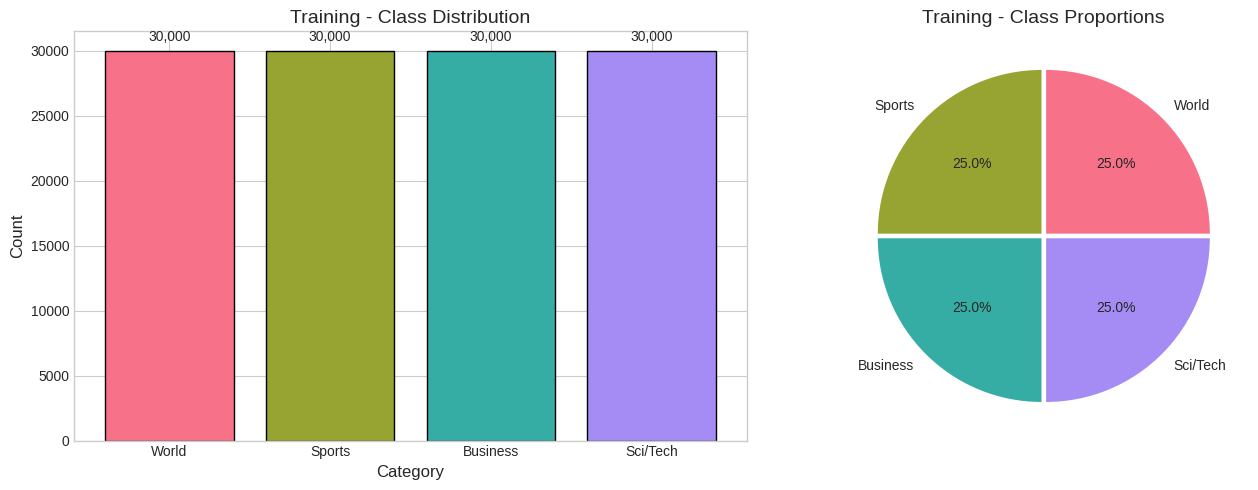


📊 Training Class Statistics:
   World: 0 (0.0%)
   Sports: 30,000 (25.0%)
   Business: 30,000 (25.0%)
   Sci/Tech: 30,000 (25.0%)


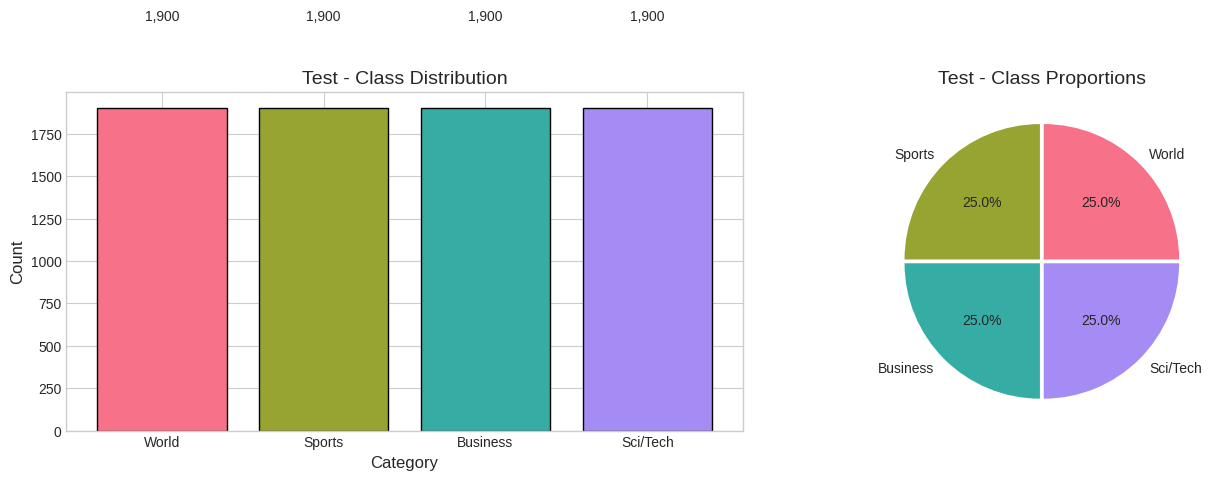


📊 Test Class Statistics:
   World: 0 (0.0%)
   Sports: 1,900 (25.0%)
   Business: 1,900 (25.0%)
   Sci/Tech: 1,900 (25.0%)


In [8]:
def analyze_class_distribution(df, split_name, label_names):
    """Analyze and visualize class distribution."""
    
    fig, axes = plt.subplots(1, 2, figsize=(14, 5))
    
    label_counts = df['label'].value_counts().sort_index()
    colors = sns.color_palette('husl', len(label_names))
    
    bars = axes[0].bar(label_names, label_counts.values, color=colors, edgecolor='black')
    axes[0].set_xlabel('Category', fontsize=12)
    axes[0].set_ylabel('Count', fontsize=12)
    axes[0].set_title(f'{split_name} - Class Distribution', fontsize=14)
    
    for bar, count in zip(bars, label_counts.values):
        axes[0].text(bar.get_x() + bar.get_width()/2, bar.get_height() + 500,
                    f'{count:,}', ha='center', va='bottom', fontsize=10)
    
    axes[1].pie(label_counts.values, labels=label_names, autopct='%1.1f%%',
                colors=colors, explode=[0.02]*len(label_names))
    axes[1].set_title(f'{split_name} - Class Proportions', fontsize=14)
    
    plt.tight_layout()
    plt.show()
    
    print(f"\n📊 {split_name} Class Statistics:")
    for idx, name in enumerate(label_names):
        count = label_counts.get(idx, 0)
        pct = count / len(df) * 100
        print(f"   {name}: {count:,} ({pct:.1f}%)")
    
    return label_counts

train_dist = analyze_class_distribution(df_train, 'Training', config.LABEL_NAMES)
test_dist = analyze_class_distribution(df_test, 'Test', config.LABEL_NAMES)

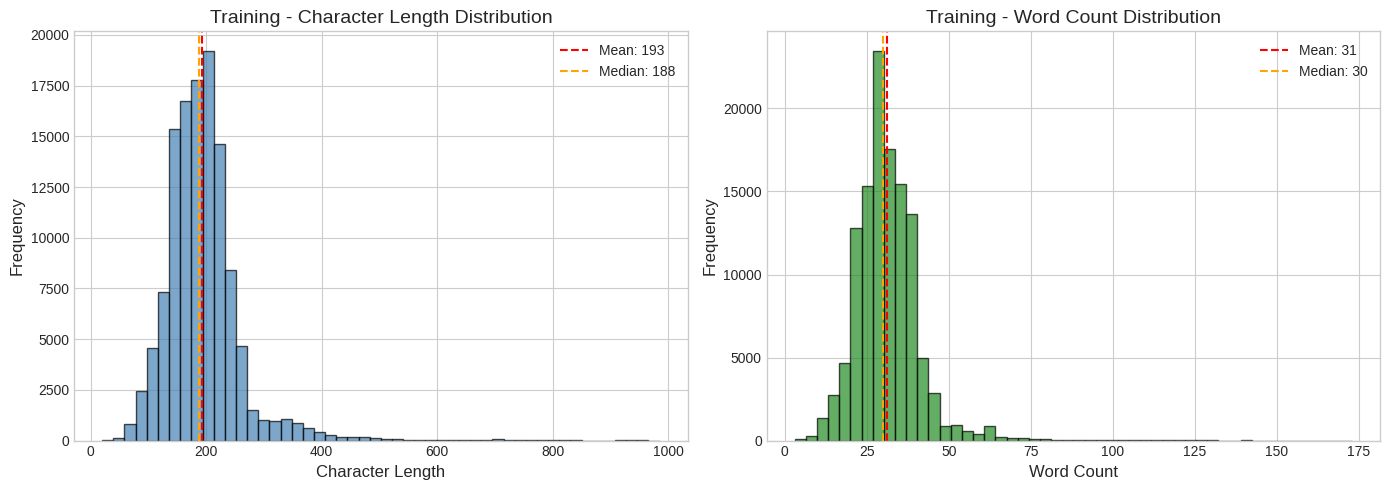


📏 Training Text Length Statistics:
   Character Length - Min: 20, Max: 985, Mean: 193.4
   Word Count - Min: 3, Max: 173, Mean: 31.1


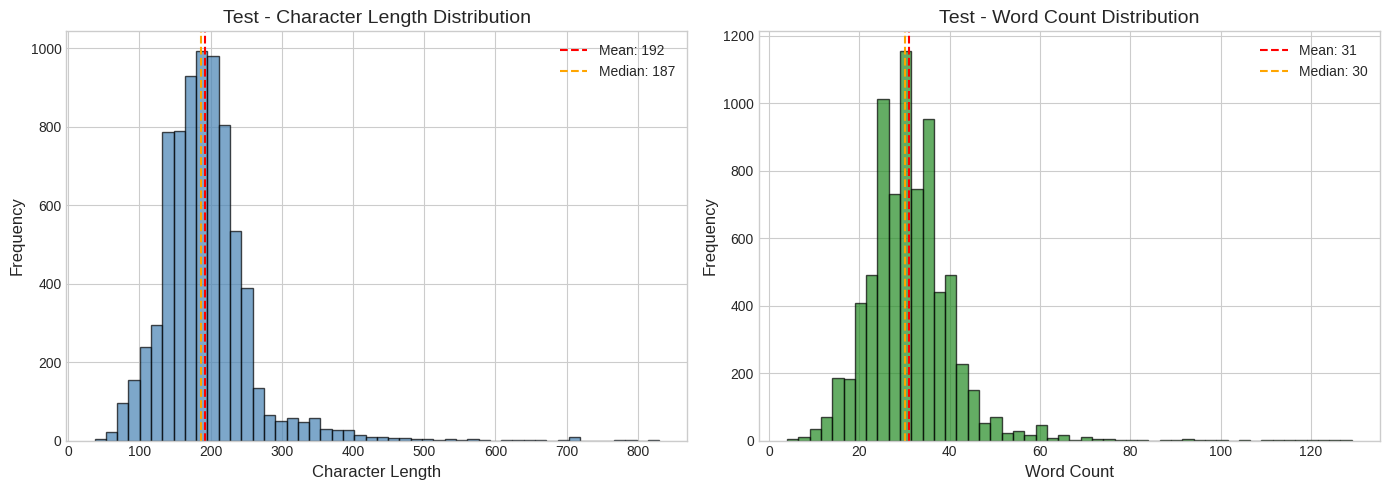


📏 Test Text Length Statistics:
   Character Length - Min: 37, Max: 830, Mean: 192.4
   Word Count - Min: 4, Max: 129, Mean: 31.0


In [9]:
def analyze_text_length(df, split_name):
    """Analyze text length distribution."""
    
    text_col = 'text' if 'text' in df.columns else 'description'
    
    df['text_length'] = df[text_col].str.len()
    df['word_count'] = df[text_col].str.split().str.len()
    
    fig, axes = plt.subplots(1, 2, figsize=(14, 5))
    
    axes[0].hist(df['text_length'], bins=50, color='steelblue', edgecolor='black', alpha=0.7)
    axes[0].axvline(df['text_length'].mean(), color='red', linestyle='--', label=f"Mean: {df['text_length'].mean():.0f}")
    axes[0].axvline(df['text_length'].median(), color='orange', linestyle='--', label=f"Median: {df['text_length'].median():.0f}")
    axes[0].set_xlabel('Character Length', fontsize=12)
    axes[0].set_ylabel('Frequency', fontsize=12)
    axes[0].set_title(f'{split_name} - Character Length Distribution', fontsize=14)
    axes[0].legend()
    
    axes[1].hist(df['word_count'], bins=50, color='forestgreen', edgecolor='black', alpha=0.7)
    axes[1].axvline(df['word_count'].mean(), color='red', linestyle='--', label=f"Mean: {df['word_count'].mean():.0f}")
    axes[1].axvline(df['word_count'].median(), color='orange', linestyle='--', label=f"Median: {df['word_count'].median():.0f}")
    axes[1].set_xlabel('Word Count', fontsize=12)
    axes[1].set_ylabel('Frequency', fontsize=12)
    axes[1].set_title(f'{split_name} - Word Count Distribution', fontsize=14)
    axes[1].legend()
    
    plt.tight_layout()
    plt.show()
    
    print(f"\n📏 {split_name} Text Length Statistics:")
    print(f"   Character Length - Min: {df['text_length'].min()}, Max: {df['text_length'].max()}, Mean: {df['text_length'].mean():.1f}")
    print(f"   Word Count - Min: {df['word_count'].min()}, Max: {df['word_count'].max()}, Mean: {df['word_count'].mean():.1f}")
    
    return df

df_train = analyze_text_length(df_train, 'Training')
df_test = analyze_text_length(df_test, 'Test')

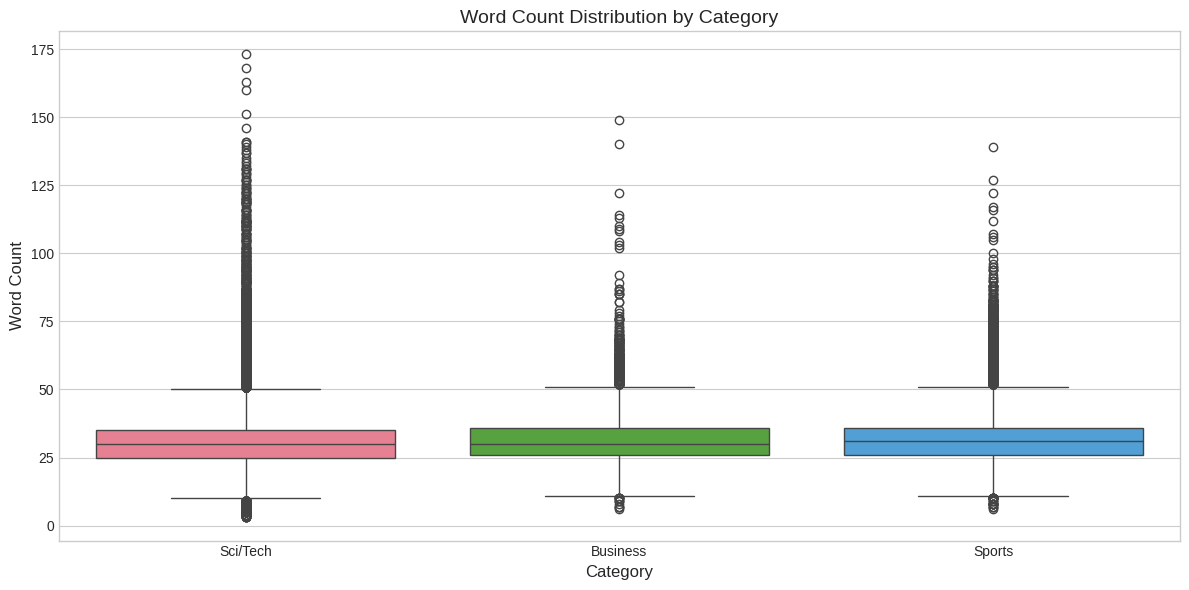


📊 Word Count Statistics by Category:
              count  mean   std  min   25%   50%   75%    max
label_name                                                   
Business    30000.0  31.3   8.6  6.0  26.0  30.0  36.0  149.0
Sci/Tech    60000.0  30.6  10.2  3.0  25.0  30.0  35.0  173.0
Sports      30000.0  31.6   9.8  6.0  26.0  31.0  36.0  139.0


In [10]:
fig, ax = plt.subplots(figsize=(12, 6))

def get_label_name(label):
    idx = label if label < len(config.LABEL_NAMES) else label - 1
    return config.LABEL_NAMES[idx]

df_train['label_name'] = df_train['label'].map(get_label_name)

sns.boxplot(data=df_train, x='label_name', y='word_count', palette='husl', ax=ax)
ax.set_xlabel('Category', fontsize=12)
ax.set_ylabel('Word Count', fontsize=12)
ax.set_title('Word Count Distribution by Category', fontsize=14)

plt.tight_layout()
plt.show()

print("\n📊 Word Count Statistics by Category:")
print(df_train.groupby('label_name')['word_count'].describe().round(1))

In [11]:
text_col = 'text' if 'text' in df_train.columns else 'description'

print("🔍 Data Quality Check:")
print("="*50)

print("\nTraining Set:")
print(f"  Missing text values: {df_train[text_col].isna().sum()}")
print(f"  Empty text values: {(df_train[text_col].str.len() == 0).sum()}")
print(f"  Duplicate texts: {df_train[text_col].duplicated().sum()}")

print("\nTest Set:")
print(f"  Missing text values: {df_test[text_col].isna().sum()}")
print(f"  Empty text values: {(df_test[text_col].str.len() == 0).sum()}")
print(f"  Duplicate texts: {df_test[text_col].duplicated().sum()}")

🔍 Data Quality Check:

Training Set:
  Missing text values: 0
  Empty text values: 0
  Duplicate texts: 1269

Test Set:
  Missing text values: 0
  Empty text values: 0
  Duplicate texts: 6


## 4. Text Preprocessing

In [12]:
import re

def preprocess_text(text):
    """
    Minimal text preprocessing.
    
    Note: BERT tokenizer handles most preprocessing internally.
    We only do minimal cleaning to preserve information.
    """
    if not isinstance(text, str):
        return ""
    
    text = ' '.join(text.split())
    
    text = re.sub(r'[\x00-\x08\x0b\x0c\x0e-\x1f\x7f-\xff]', '', text)
    
    return text.strip()

sample_text = "  This is   a sample   text with   extra spaces.  "
print(f"Original: '{sample_text}'")
print(f"Processed: '{preprocess_text(sample_text)}'")

Original: '  This is   a sample   text with   extra spaces.  '
Processed: 'This is a sample text with extra spaces.'


In [13]:
def preprocess_dataset(example):
    """Preprocess a single example."""
    if 'text' in example:
        example['text'] = preprocess_text(example['text'])
    elif 'description' in example:
        example['text'] = preprocess_text(example['description'])
    
    if 'label' in example and example['label'] > 0:
        example['label'] = example['label'] - 1
    
    return example

print("🔄 Applying preprocessing...")
processed_dataset = raw_dataset.map(preprocess_dataset, desc="Preprocessing")
print("✅ Preprocessing complete!")

sample_labels = [processed_dataset['train'][i]['label'] for i in range(100)]
print(f"\n🔍 Verification - Label range: min={min(sample_labels)}, max={max(sample_labels)}")

🔄 Applying preprocessing...


Preprocessing:   0%|          | 0/120000 [00:00<?, ? examples/s]

Preprocessing:   0%|          | 0/7600 [00:00<?, ? examples/s]

✅ Preprocessing complete!

🔍 Verification - Label range: min=2, max=3


## 5. Tokenization Strategy

In [14]:
print(f"📦 Loading tokenizer: {config.DEFAULT_TOKENIZER}")
tokenizer = AutoTokenizer.from_pretrained(config.DEFAULT_TOKENIZER)

print(f"\n✅ Tokenizer loaded!")
print(f"   Vocabulary size: {tokenizer.vocab_size:,}")
print(f"   Model max length: {tokenizer.model_max_length}")
print(f"   Special tokens: {tokenizer.special_tokens_map}")

📦 Loading tokenizer: bert-base-uncased


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]


✅ Tokenizer loaded!
   Vocabulary size: 30,522
   Model max length: 512
   Special tokens: {'unk_token': '[UNK]', 'sep_token': '[SEP]', 'pad_token': '[PAD]', 'cls_token': '[CLS]', 'mask_token': '[MASK]'}


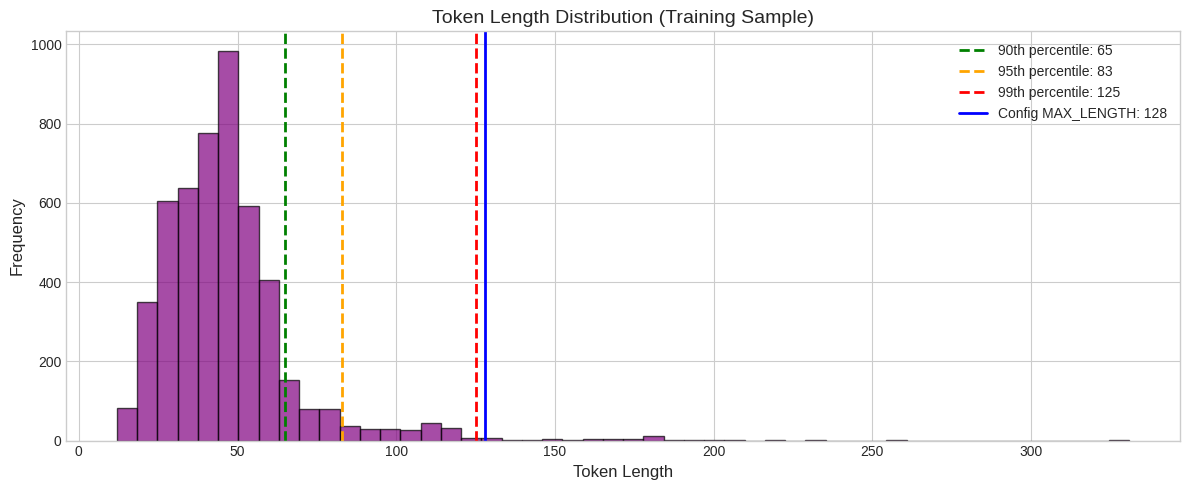


📊 Token Length Statistics:
   Min: 12
   Max: 331
   Mean: 46.7
   Median: 44.0
   Std: 22.3

📏 Percentiles:
   50th percentile: 44 tokens
   75th percentile: 54 tokens
   90th percentile: 65 tokens
   95th percentile: 83 tokens
   99th percentile: 125 tokens

✅ Coverage with MAX_LENGTH=128: 99.1% of samples


In [15]:
def analyze_tokenization_length(dataset, tokenizer, sample_size=5000):
    """
    Analyze the distribution of token lengths to determine optimal max_length.
    """
    texts = dataset['train']['text'][:sample_size]
    
    token_lengths = []
    for text in texts:
        tokens = tokenizer(text, add_special_tokens=True)
        token_lengths.append(len(tokens['input_ids']))
    
    token_lengths = np.array(token_lengths)
    
    fig, ax = plt.subplots(figsize=(12, 5))
    
    ax.hist(token_lengths, bins=50, color='purple', edgecolor='black', alpha=0.7)
    
    percentiles = [90, 95, 99]
    colors = ['green', 'orange', 'red']
    for pct, color in zip(percentiles, colors):
        val = np.percentile(token_lengths, pct)
        ax.axvline(val, color=color, linestyle='--', linewidth=2, label=f'{pct}th percentile: {val:.0f}')
    
    ax.axvline(config.MAX_LENGTH, color='blue', linestyle='-', linewidth=2, label=f'Config MAX_LENGTH: {config.MAX_LENGTH}')
    
    ax.set_xlabel('Token Length', fontsize=12)
    ax.set_ylabel('Frequency', fontsize=12)
    ax.set_title('Token Length Distribution (Training Sample)', fontsize=14)
    ax.legend()
    
    plt.tight_layout()
    plt.show()
    
    print("\n📊 Token Length Statistics:")
    print(f"   Min: {token_lengths.min()}")
    print(f"   Max: {token_lengths.max()}")
    print(f"   Mean: {token_lengths.mean():.1f}")
    print(f"   Median: {np.median(token_lengths):.1f}")
    print(f"   Std: {token_lengths.std():.1f}")
    
    print(f"\n📏 Percentiles:")
    for pct in [50, 75, 90, 95, 99]:
        print(f"   {pct}th percentile: {np.percentile(token_lengths, pct):.0f} tokens")
    
    coverage = (token_lengths <= config.MAX_LENGTH).mean() * 100
    print(f"\n✅ Coverage with MAX_LENGTH={config.MAX_LENGTH}: {coverage:.1f}% of samples")
    
    return token_lengths

token_lengths = analyze_tokenization_length(processed_dataset, tokenizer)

In [16]:
sample_text = processed_dataset['train'][0]['text']

print("🔤 Tokenization Example:")
print("="*80)
print(f"\nOriginal text:\n{sample_text[:300]}...")

encoded = tokenizer(
    sample_text,
    max_length=config.MAX_LENGTH,
    padding=config.PADDING,
    truncation=config.TRUNCATION,
    return_tensors='pt'
)

print(f"\n📦 Encoded output:")
print(f"   input_ids shape: {encoded['input_ids'].shape}")
print(f"   attention_mask shape: {encoded['attention_mask'].shape}")

print(f"\n📝 First 20 tokens:")
tokens = tokenizer.convert_ids_to_tokens(encoded['input_ids'][0][:20])
print(f"   {tokens}")

print(f"\n🔢 First 20 token IDs:")
print(f"   {encoded['input_ids'][0][:20].tolist()}")

🔤 Tokenization Example:

Original text:
Reuters - Short-sellers, Wall Street's dwindling\band of ultra-cynics, are seeing green again....

📦 Encoded output:
   input_ids shape: torch.Size([1, 128])
   attention_mask shape: torch.Size([1, 128])

📝 First 20 tokens:
   ['[CLS]', 'reuters', '-', 'short', '-', 'sellers', ',', 'wall', 'street', "'", 's', 'd', '##wind', '##ling', '\\', 'band', 'of', 'ultra', '-', 'cy']

🔢 First 20 token IDs:
   [101, 26665, 1011, 2460, 1011, 19041, 1010, 2813, 2395, 1005, 1055, 1040, 11101, 2989, 1032, 2316, 1997, 11087, 1011, 22330]


## 6. Dataset Preparation for Training

In [17]:
def tokenize_function(examples):
    """
    Tokenize a batch of examples.
    
    This function is designed to work with HuggingFace's map() function.
    """
    return tokenizer(
        examples['text'],
        max_length=config.MAX_LENGTH,
        padding=config.PADDING,
        truncation=config.TRUNCATION
    )

print("🔄 Tokenizing dataset...")
tokenized_dataset = processed_dataset.map(
    tokenize_function,
    batched=True,
    desc="Tokenizing",
    remove_columns=['text']
)

print("\n✅ Tokenization complete!")
print(tokenized_dataset)

🔄 Tokenizing dataset...


Tokenizing:   0%|          | 0/120000 [00:00<?, ? examples/s]

Tokenizing:   0%|          | 0/7600 [00:00<?, ? examples/s]


✅ Tokenization complete!
DatasetDict({
    train: Dataset({
        features: ['label', 'title', 'description', 'input_ids', 'token_type_ids', 'attention_mask'],
        num_rows: 120000
    })
    test: Dataset({
        features: ['label', 'title', 'description', 'input_ids', 'token_type_ids', 'attention_mask'],
        num_rows: 7600
    })
})


In [18]:

print("📊 Creating train/validation split...")

from datasets import ClassLabel

tokenized_dataset = tokenized_dataset.cast_column('label', ClassLabel(names=config.LABEL_NAMES))

train_val_split = tokenized_dataset['train'].train_test_split(
    test_size=0.1,
    seed=config.SEED,
    stratify_by_column='label'
)

final_dataset = DatasetDict({
    'train': train_val_split['train'],
    'validation': train_val_split['test'],
    'test': tokenized_dataset['test']
})

print("\n✅ Final dataset structure:")
print(final_dataset)

for split, data in final_dataset.items():
    print(f"\n{split}: {len(data):,} samples")

📊 Creating train/validation split...


Casting the dataset:   0%|          | 0/120000 [00:00<?, ? examples/s]

Casting the dataset:   0%|          | 0/7600 [00:00<?, ? examples/s]


✅ Final dataset structure:
DatasetDict({
    train: Dataset({
        features: ['label', 'title', 'description', 'input_ids', 'token_type_ids', 'attention_mask'],
        num_rows: 108000
    })
    validation: Dataset({
        features: ['label', 'title', 'description', 'input_ids', 'token_type_ids', 'attention_mask'],
        num_rows: 12000
    })
    test: Dataset({
        features: ['label', 'title', 'description', 'input_ids', 'token_type_ids', 'attention_mask'],
        num_rows: 7600
    })
})

train: 108,000 samples

validation: 12,000 samples

test: 7,600 samples


In [ ]:
print("🔍 Dataset Verification:")
print("="*50)

sample = final_dataset['train'][0]
print(f"\nSample features: {list(sample.keys())}")
print(f"\ninput_ids length: {len(sample['input_ids'])}")
print(f"attention_mask length: {len(sample['attention_mask'])}")
print(f"label: {sample['label']} ({config.LABEL_NAMES[sample['label']]})")

🔍 Dataset Verification:

Sample features: ['label', 'title', 'description', 'input_ids', 'token_type_ids', 'attention_mask']

input_ids length: 128
attention_mask length: 128
label: 1 (Sports)


In [20]:
final_dataset.set_format('torch')

print("✅ Dataset format set to PyTorch tensors")

sample = final_dataset['train'][0]
print(f"\nSample tensor types:")
for key, value in sample.items():
    print(f"   {key}: {type(value).__name__}, shape: {value.shape if hasattr(value, 'shape') else 'scalar'}")

✅ Dataset format set to PyTorch tensors

Sample tensor types:
   label: Tensor, shape: torch.Size([])
   title: str, shape: scalar
   description: str, shape: scalar
   input_ids: Tensor, shape: torch.Size([128])
   token_type_ids: Tensor, shape: torch.Size([128])
   attention_mask: Tensor, shape: torch.Size([128])


## 7. Save Processed Data

In [21]:
print("💾 Saving processed dataset...")

save_path = os.path.join(config.DATA_DIR, 'ag_news_tokenized')
final_dataset.save_to_disk(save_path)

print(f"✅ Dataset saved to: {save_path}")

💾 Saving processed dataset...


Saving the dataset (0/1 shards):   0%|          | 0/108000 [00:00<?, ? examples/s]

Saving the dataset (0/1 shards):   0%|          | 0/12000 [00:00<?, ? examples/s]

Saving the dataset (0/1 shards):   0%|          | 0/7600 [00:00<?, ? examples/s]

✅ Dataset saved to: ./processed_data/ag_news_tokenized


In [22]:
config_dict = {
    'dataset_name': config.DATASET_NAME,
    'max_length': config.MAX_LENGTH,
    'padding': config.PADDING,
    'truncation': config.TRUNCATION,
    'label_names': config.LABEL_NAMES,
    'num_labels': config.NUM_LABELS,
    'model_checkpoints': config.MODEL_CHECKPOINTS,
    'default_tokenizer': config.DEFAULT_TOKENIZER,
    'seed': config.SEED,
    'train_size': len(final_dataset['train']),
    'val_size': len(final_dataset['validation']),
    'test_size': len(final_dataset['test'])
}

config_path = os.path.join(config.DATA_DIR, 'ag_news_config.json')
with open(config_path, 'w') as f:
    json.dump(config_dict, f, indent=2)

print(f"✅ Configuration saved to: {config_path}")
print("\n📋 Saved configuration:")
print(json.dumps(config_dict, indent=2))

✅ Configuration saved to: ./processed_data/ag_news_config.json

📋 Saved configuration:
{
  "dataset_name": "sh0416/ag_news",
  "max_length": 128,
  "padding": "max_length",
  "truncation": true,
  "label_names": [
    "World",
    "Sports",
    "Business",
    "Sci/Tech"
  ],
  "num_labels": 4,
  "model_checkpoints": {
    "bert-base": "bert-base-uncased",
    "distilbert": "distilbert-base-uncased",
    "tinybert": "huawei-noah/TinyBERT_General_4L_312D"
  },
  "default_tokenizer": "bert-base-uncased",
  "seed": 42,
  "train_size": 108000,
  "val_size": 12000,
  "test_size": 7600
}


In [23]:
print("🔍 Verifying saved data...")

from datasets import load_from_disk

loaded_dataset = load_from_disk(save_path)
print(f"\n✅ Dataset loaded successfully!")
print(loaded_dataset)

🔍 Verifying saved data...

✅ Dataset loaded successfully!
DatasetDict({
    train: Dataset({
        features: ['label', 'title', 'description', 'input_ids', 'token_type_ids', 'attention_mask'],
        num_rows: 108000
    })
    validation: Dataset({
        features: ['label', 'title', 'description', 'input_ids', 'token_type_ids', 'attention_mask'],
        num_rows: 12000
    })
    test: Dataset({
        features: ['label', 'title', 'description', 'input_ids', 'token_type_ids', 'attention_mask'],
        num_rows: 7600
    })
})
